In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}
// Avoid scrollable output for many plots

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import datetime
import numpy as np
import tqdm
import seaborn as sns; sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import randint
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
#pandas.set_option("display.precision", 8)
timestamp = datetime.datetime.now().strftime("%Y-%b-%d")

# Load the data

In [3]:
df_raw = pd.read_parquet('data_2020-Oct-12.parquet')
print('Number cars: {}'.format(df_raw.shape[0]));
df_raw.drop_duplicates(inplace=True)
df_raw['engineSize'] = pd.to_numeric(df_raw['engineSize'].str.replace(',','.'))
print('Number cars: {}'.format(df_raw.shape[0]));
df_raw.head()

Number cars: 1184
Number cars: 532


headline  year  odometer     price  \
0  Skoda Octavia 1,5 TSi 150 Style Combi DSG 5d  2020   13000.0  264900.0   
1     Skoda Octavia 1,4 TSi 140 Elegance DSG 5d  2014   98000.0  139800.0   
2           Skoda Octavia 1,2 TSi 110 Active 5d  2016  145000.0  128980.0   
3     Skoda Octavia 1,5 TSi 150 Ambition DSG 5d  2020   10000.0  239900.0   
5      Skoda Octavia 1,0 TSi 115 Style Combi 5d  2018   38000.0  199900.0   

                                         description  horsepower  \
0  Business Line,, 16" Alufælge, 2 Zone Klima, Pa...       150.0   
1  !!SOLGT!!Candy White, 18" Originale Alufælge, ...       140.0   
2  Moon White Metallic, Fartpilot, Navigation, Mu...       110.0   
3  Metallak - Moon White, Aut.Gear/Tiptronic, Air...       150.0   
5  BM. STYLE MODEL !! 16" Alufælge, 2 Zone Klima,...       115.0   

                  region  transmissionManual  fuelTypeGasoline  \
0  Syd- og Sønderjylland               False              True   
1                    Fyn               False              True   
2             Østjylland                True              True   
3            Nordjylland               False              True   
5   Syd- og Vestsjælland                True              True   

   carTypeStationCar  engineSize      trim  
0               True         1.5     Style  
1              False         1.4  Elegance  
2              False         1.2    Active  
3              False         1.5  Ambition  
5               True         1.0     Style

In [4]:
df_raw.describe()

year       odometer          price  horsepower  engineSize
count   532.000000     532.000000     532.000000  532.000000  532.000000
mean   2015.716165  100221.140977  171070.804511  131.642857    1.529699
std       2.797679   63043.494295   69149.197062   26.520224    0.291017
min    2010.000000    1000.000000   49900.000000   86.000000    1.000000
25%    2014.000000   48750.000000  119900.000000  105.000000    1.400000
50%    2016.000000   97500.000000  164900.000000  122.000000    1.500000
75%    2018.000000  145500.000000  219900.000000  150.000000    1.600000
max    2021.000000  281000.000000  499900.000000  245.000000    2.000000

In [5]:
# Clean
print('Number cars: {}'.format(df_raw.shape[0]));
df_raw = df_raw[df_raw.price < 400_000]
print('Number cars: {}'.format(df_raw.shape[0]));

Number cars: 532
Number cars: 530


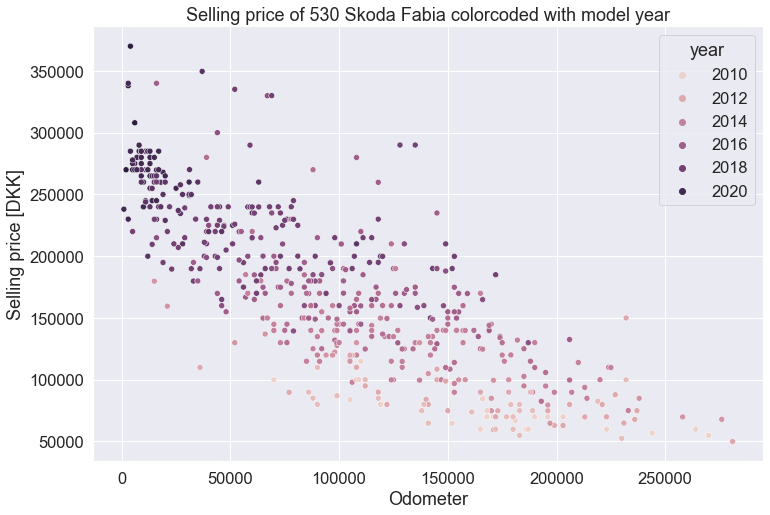

In [6]:
plt.rcParams["figure.figsize"] =(12,8)
ax = sns.scatterplot(x="odometer", y="price", hue="year", data=df_raw)
ax.set_ylabel('Selling price [DKK]');
ax.set_xlabel('Odometer');
ax.set_title(f'Selling price of {df_raw.shape[0]} Skoda Fabia colorcoded with model year');

# Prepare data for modelling

In [7]:
df_raw.head(10)

headline  year  odometer  \
0        Skoda Octavia 1,5 TSi 150 Style Combi DSG 5d  2020   13000.0   
1           Skoda Octavia 1,4 TSi 140 Elegance DSG 5d  2014   98000.0   
2                 Skoda Octavia 1,2 TSi 110 Active 5d  2016  145000.0   
3           Skoda Octavia 1,5 TSi 150 Ambition DSG 5d  2020   10000.0   
5            Skoda Octavia 1,0 TSi 115 Style Combi 5d  2018   38000.0   
6               Skoda Octavia 1,4 TSi 122 Elegance 5d  2010  203000.0   
7   Skoda Octavia 1,4 TSi 122 Ambition Combi Green...  2013   98000.0   
8        Skoda Octavia 1,5 TSi 150 Style Combi DSG 5d  2019   28000.0   
9     Skoda Octavia 1,4 TSi 140 Elegance Combi DSG 5d  2015  124000.0   
10        Skoda Octavia 1,4 TSi 140 Elegance Combi 5d  2015   91000.0   

       price                                        description  horsepower  \
0   264900.0  Business Line,, 16" Alufælge, 2 Zone Klima, Pa...       150.0   
1   139800.0  !!SOLGT!!Candy White, 18" Originale Alufælge, ...       140.0   
2   128980.0  Moon White Metallic, Fartpilot, Navigation, Mu...       110.0   
3   239900.0  Metallak - Moon White, Aut.Gear/Tiptronic, Air...       150.0   
5   199900.0  BM. STYLE MODEL !! 16" Alufælge, 2 Zone Klima,...       115.0   
6    69900.0  15" Alufælge, 2 Zone Klima, Fjernb. C.Lås, Par...       122.0   
7   122300.0  BENK NY KÆDEKIT MONTERET VED 83000 KM. 6 GIAR,...       122.0   
8   249900.0  Super Flot Skoda Octavia Combi Med Det Lækre D...       150.0   
9   159900.0  Aut.Gear/Tiptronic, 16" Alufælge, 2 Zone Klima...       140.0   
10  169900.0  BLUETOOTH - BLUETOOTH AUDIO - MULTIRAT - AFT T...       140.0   

                   region  transmissionManual  fuelTypeGasoline  \
0   Syd- og Sønderjylland               False              True   
1                     Fyn               False              True   
2              Østjylland                True              True   
3             Nordjylland               False              True   
5    Syd- og Vestsjælland                True              True   
6                     Fyn                True              True   
7   Syd- og Sønderjylland                True              True   
8                     Fyn               False              True   
9            Nordsjælland               False              True   
10             Østjylland                True              True   

    carTypeStationCar  engineSize      trim  
0                True         1.5     Style  
1               False         1.4  Elegance  
2               False         1.2    Active  
3               False         1.5  Ambition  
5                True         1.0     Style  
6               False         1.4  Elegance  
7                True         1.4  Ambition  
8                True         1.5     Style  
9                True         1.4  Elegance  
10               True         1.4  Elegance

In [8]:
df_raw.trim.unique()

array(['Style', 'Elegance', 'Active', 'Ambition', 'Ambiente', 'Greenline',
       'L&K', 'Tour de France', 'Celebration', 'RS', 'Classic', 'Dynamic',
       'Joy', 'Sport', 'Family'], dtype=object)

In [9]:
# label_encoder object knows how to understand word labels.
df = df_raw.copy()
label_encoders = {}
encoded_labels = [
    'region',
    'trim',  # They have an order to it that makes it senseless to label encode
    'fuelTypeGasoline',
    'carTypeStationCar',
    'transmissionManual',
    #'engineSize',
    #'horsepower'
]

for label in encoded_labels:
    le = preprocessing.LabelEncoder()
    df[label] = le.fit_transform(df[label])
    label_encoders[label] = le
df.head()

headline  year  odometer     price  \
0  Skoda Octavia 1,5 TSi 150 Style Combi DSG 5d  2020   13000.0  264900.0   
1     Skoda Octavia 1,4 TSi 140 Elegance DSG 5d  2014   98000.0  139800.0   
2           Skoda Octavia 1,2 TSi 110 Active 5d  2016  145000.0  128980.0   
3     Skoda Octavia 1,5 TSi 150 Ambition DSG 5d  2020   10000.0  239900.0   
5      Skoda Octavia 1,0 TSi 115 Style Combi 5d  2018   38000.0  199900.0   

                                         description  horsepower  region  \
0  Business Line,, 16" Alufælge, 2 Zone Klima, Pa...       150.0       5   
1  !!SOLGT!!Candy White, 18" Originale Alufælge, ...       140.0       0   
2  Moon White Metallic, Fartpilot, Navigation, Mu...       110.0       8   
3  Metallak - Moon White, Aut.Gear/Tiptronic, Air...       150.0       3   
5  BM. STYLE MODEL !! 16" Alufælge, 2 Zone Klima,...       115.0       6   

   transmissionManual  fuelTypeGasoline  carTypeStationCar  engineSize  trim  
0                   0                 1                  1         1.5    13  
1                   0                 1                  0         1.4     6  
2                   1                 1                  0         1.2     0  
3                   0                 1                  0         1.5     2  
5                   1                 1                  1         1.0    13

In [10]:
features_raw = df.drop(['description', 'headline'], axis=1)
# label_encoder object knows how to understand word labels.
features_raw = pd.get_dummies(features_raw)
features_raw.head()

year  odometer     price  horsepower  region  transmissionManual  \
0  2020   13000.0  264900.0       150.0       5                   0   
1  2014   98000.0  139800.0       140.0       0                   0   
2  2016  145000.0  128980.0       110.0       8                   1   
3  2020   10000.0  239900.0       150.0       3                   0   
5  2018   38000.0  199900.0       115.0       6                   1   

   fuelTypeGasoline  carTypeStationCar  engineSize  trim  
0                 1                  1         1.5    13  
1                 1                  0         1.4     6  
2                 1                  0         1.2     0  
3                 1                  0         1.5     2  
5                 1                  1         1.0    13

In [11]:
# Labels are the values we want to predict, often also called y
labels = np.array(features_raw['price'])

# Remove the labels from the features, often also called X
features = features_raw.drop('price', axis=1)

# Saving feature names for later use
feature_list = features.columns.tolist()

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

# Train the model

In [12]:
class Testmodel:
    def __init__(self, name, model):
        self.name = name
        self.model_base = model
        self.test_output = None

# Instantiate model with X decision trees
models = {
    'RandomForest': Testmodel('RandomForest', RandomForestRegressor()),
    'ExtraTrees':   Testmodel('ExtraTrees',   ExtraTreesRegressor()),
    'AdaBoost':     Testmodel('AdaBoost',     AdaBoostRegressor(base_estimator=RandomForestRegressor())),
}


def error_output(model):
    # Compare the true HP values with the predicted as save as a model attribute
    true_price = test_labels
    pred_price = model.predict(test_features)
    df_out             = pd.DataFrame({'True price': true_price, 'Predicted price': pred_price})
    df_out['Error']    = df_out['Predicted price'] - df_out['True price']
    df_out['absError'] = np.abs(df_out['Predicted price'] - df_out['True price'])
    return df_out

In [13]:
# Train the models on training data
for name, m in tqdm.tqdm(models.items()):
    m.model_base.fit(train_features, train_labels);

100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


# Evaluate the model

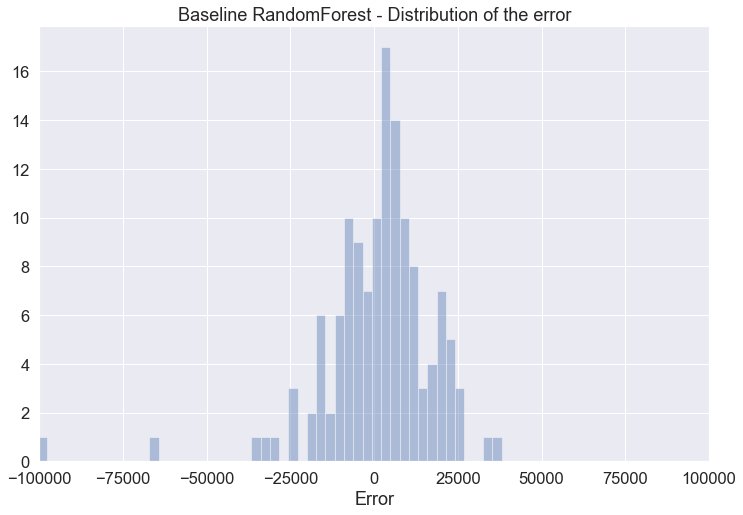

Model:                    Baseline RandomForest
Mean absolute error:       11701.31
Median absolute error:      8557.53
R2 score:                     93.92%



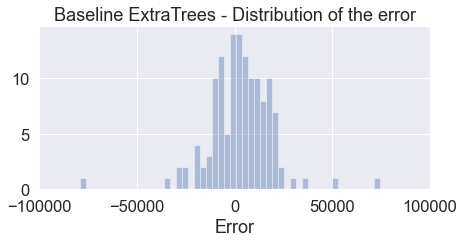

Model:                    Baseline ExtraTrees
Mean absolute error:       11721.11
Median absolute error:      9400.02
R2 score:                     94.20%



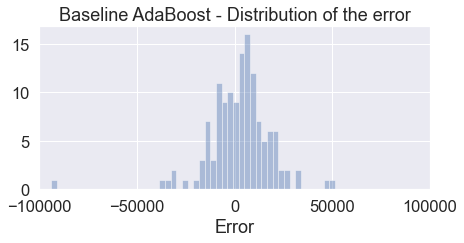

Model:                    Baseline AdaBoost
Mean absolute error:       11568.34
Median absolute error:      8431.00
R2 score:                     94.26%



In [14]:
def print_model_metrics(name, model):

    # Visualize distribution of the error
    output = error_output(model)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (7,3)
    ax = sns.distplot(output['Error'], kde=False, bins=50);
    ax.set_xlim(-100000, 100000)
    ax.set_title(f'{name} - Distribution of the error');
    plt.show()

    pred_labels = model.predict(test_features)
    #print(model.test_output['Error'].describe())
    print(f'Model:                    {name}')
    print(f'Mean absolute error:      {mean_absolute_error(test_labels, pred_labels):9.2f}')
    print(f'Median absolute error:    {median_absolute_error(test_labels, pred_labels):9.2f}')
    print(f'R2 score:                 {r2_score(test_labels, pred_labels):10.2%}')
    print()

for name, m in models.items():
    print_model_metrics(f'Baseline {m.name}', m.model_base)

In [15]:
for name, m in models.items():
    print(name)
    print(m.model_base.get_params())
    print()

RandomForest
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

ExtraTrees
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

AdaBoost
{'base_estimator__bootstrap': True, 'base_estimator__ccp_alpha': 0.0, 'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_featur

In [16]:
# The 5 worst predictions
for name, m in models.items():
    print(m.name)
    print(error_output(m.model_base).sort_values('absError', ascending=False).head(2))
    print()

RandomForest
    True price  Predicted price      Error   absError
50    269900.0        169523.45 -100376.55  100376.55
38    279900.0        214334.67  -65565.33   65565.33

ExtraTrees
     True price  Predicted price     Error  absError
50     269900.0        190813.94 -79086.06  79086.06
110    199990.0        274621.90  74631.90  74631.90

AdaBoost
     True price  Predicted price    Error  absError
50     269900.0         176090.0 -93810.0   93810.0
110    199990.0         251337.0  51347.0   51347.0



In [17]:
# The 5 best predictions
for name, m in models.items():
    print(m.name)
    print(error_output(m.model_base).sort_values('absError', ascending=True).head(2))
    print()

RandomForest
    True price  Predicted price  Error  absError
58     73800.0          73772.0  -28.0      28.0
35     94800.0          95014.3  214.3     214.3

ExtraTrees
    True price  Predicted price  Error  absError
62    239900.0         239900.0    0.0       0.0
49    189900.0         189956.0   56.0      56.0

AdaBoost
    True price  Predicted price  Error  absError
65    179900.0         180014.3  114.3     114.3
69     69800.0          69589.0 -211.0     211.0



# Tune the hyper parameters

In [18]:
# Define the search space for each model

n_estimators_common = [100, 500, 1000]

models['AdaBoost'].parameter_grid = {
    #'n_estimators': [10, 100, 750, 1000,1500],
    'n_estimators': n_estimators_common,
    #'max_depth': [None] + [int(x) for x in np.linspace(1, 150,16)],
    #'min_samples_split': [2,3,4,5,6,7,8,9,10],
    #'min_samples_leaf': [1,2,3,4,5,7,8,9,10],
    #'max_features': ['auto', 'sqrt', 'log2', None],
    # Select for subspace search
    #'min_samples_split': [4],
}

models['RandomForest'].parameter_grid = {
    #'n_estimators': [10, 100, 750, 1000,1500],
    'n_estimators': n_estimators_common,
    #'max_depth': [None] + [int(x) for x in np.linspace(1, 150,16)],
    'max_depth': [None] + [10, 100, 1000],
    #'min_samples_split': [2,3,4,5,6,7,8,9,10],
    #'min_samples_leaf': [1,2,3,4,5,7,8,9,10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    # Select for subspace search
    #'min_samples_split': [4],
}

models['ExtraTrees'].parameter_grid = {
    #'n_estimators': [10, 100, 750, 1000,1500],
    'n_estimators': n_estimators_common,
    #'max_depth': [None] + [int(x) for x in np.linspace(1, 150,16)],
    'max_depth': [None] + [10, 100, 1000],
    #'min_samples_split': [2,3,4,5,6,7,8,9,10],
    #'min_samples_leaf': [1,2,3,4,5,7,8,9,10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    # Select for subspace search
    #'min_samples_split': [4],
}


In [19]:
for name, m in tqdm.tqdm(models.items()):
    print(name)
    # Use RandomizedSearchCV for explorative search and GridSearchCV for detailed search

    # Use this for sampling a large parameter space
    #search_model=RandomizedSearchCV(
    #   n_iter=10,
    #    cv=3,
    #    verbose=3,
    #    estimator=RandomForestRegressor(),
    #    param_distributions=parameter_grid,
    #    #random_state=42,
    #    n_jobs = -1
    #)

    search_model=GridSearchCV(
        cv=10,
        verbose=2,
        estimator=m.model_base,
        param_grid=m.parameter_grid,
        n_jobs=-1
    )

    # Fit the random search model
    search_model.fit(train_features, train_labels)

    # Tuning Results
    df_scores = pd.DataFrame(search_model.cv_results_).sort_values(by='rank_test_score')
    m.tuned_params = search_model.best_params_
    print(name)
    print(f'Best score:      {search_model.best_score_:.4f}')
    print(f'Best parameters: {m.tuned_params}')
    print()

  0%|          | 0/3 [00:00<?, ?it/s]

RandomForest
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   20.0s finished
 33%|███▎      | 1/3 [00:21<00:42, 21.30s/it]

RandomForest
Best score:      0.9112
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 1000}

ExtraTrees
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   13.6s finished
 67%|██████▋   | 2/3 [00:35<00:19, 19.03s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ExtraTrees
Best score:      0.9124
Best parameters: {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 100}

AdaBoost
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.7min finished
100%|██████████| 3/3 [03:31<00:00, 70.36s/it]

AdaBoost
Best score:      0.9133
Best parameters: {'n_estimators': 100}



# Compare baseline model vs tuned model

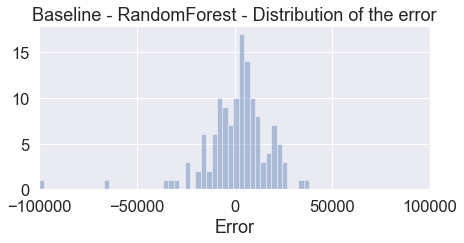

Model:                    Baseline - RandomForest
Mean absolute error:       11701.31
Median absolute error:      8557.53
R2 score:                     93.92%



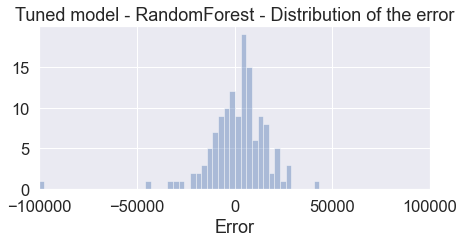

Model:                    Tuned model - RandomForest
Mean absolute error:       10779.68
Median absolute error:      7804.45
R2 score:                     94.79%




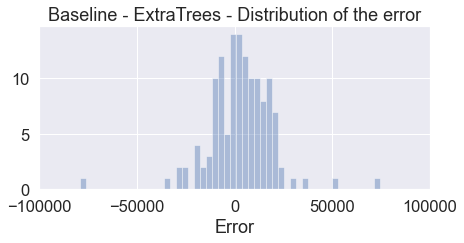

Model:                    Baseline - ExtraTrees
Mean absolute error:       11721.11
Median absolute error:      9400.02
R2 score:                     94.20%



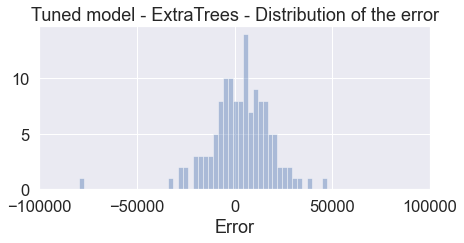

Model:                    Tuned model - ExtraTrees
Mean absolute error:       11769.50
Median absolute error:      9541.30
R2 score:                     94.71%




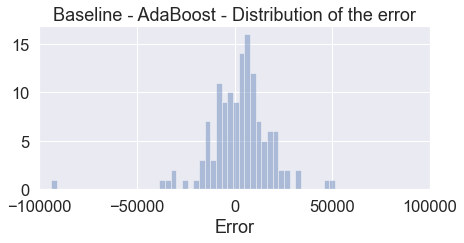

Model:                    Baseline - AdaBoost
Mean absolute error:       11568.34
Median absolute error:      8431.00
R2 score:                     94.26%



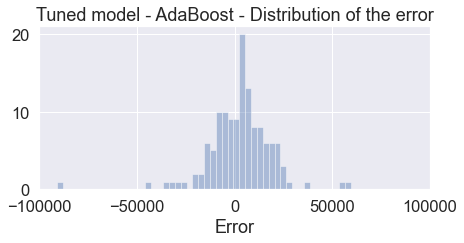

Model:                    Tuned model - AdaBoost
Mean absolute error:       11671.91
Median absolute error:      8040.00
R2 score:                     93.96%




In [20]:
for name, m in models.items():

    # Instantiate model with X decision trees
    m.model_tuned = clone(m.model_base)
    m.model_tuned.set_params(**m.tuned_params)

    # Train the tuned model on training data
    m.model_tuned.fit(train_features, train_labels)

    print_model_metrics(f'Baseline - {m.name}',       m.model_base)
    print_model_metrics(f'Tuned model - {m.name}',    m.model_tuned)
    print()

# Feature importance

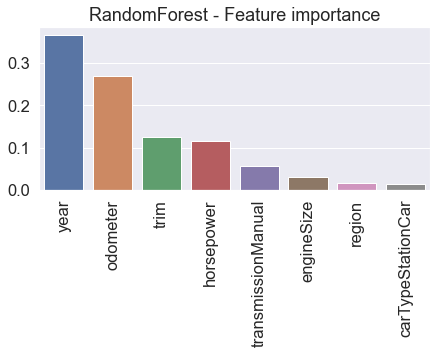

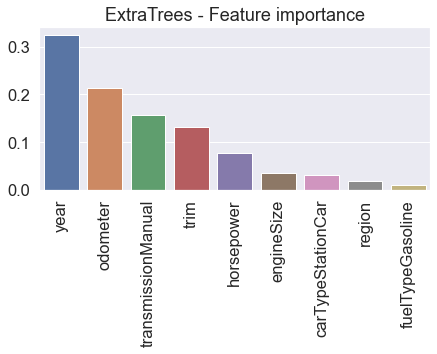

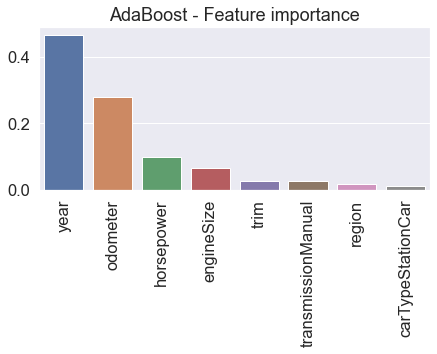

In [21]:
for name, m in models.items():

    # Get numerical feature importances
    importances = m.model_tuned.feature_importances_.tolist()

    # List of tuples with variable and importance
    feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    # Print out the feature and importances
    #[print(f'Variable: {f:25} Importance: {i:.4f}') for f,i in feature_importances if i > 0.01];

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (7,3)
    _feature    = [f for f,i in feature_importances if i > 0.01]
    _importance = [i for f,i in feature_importances if i > 0.01]
    ax = sns.barplot(x=_feature, y=_importance)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
    ax.set_title(f'{m.name} - Feature importance');
    plt.show()

# Explain a prediction

In [22]:
categorical_features = np.argwhere(np.array([len(set(features[:,x])) for x in range(features.shape[1])]) <= 10).flatten()
explainer = lime.lime_tabular.LimeTabularExplainer(train_features,
        feature_names=feature_list,
        class_names=['price'],
        categorical_features=categorical_features,
        mode='regression')

In [23]:
# Take a random example and inspect how it is priced
i=17

# Print the params of the selected test
for k,j in enumerate(test_features[i]):
    if j:
        print(f'{feature_list[k]:20} = {j}')
        #test_features[i]
print()

for name, m in models.items():
    print(name)
    print(f'Sales price:     {test_labels[i]:6.0f}')
    print(f'Predicted price: {m.model_tuned.predict(test_features)[i]:6.0f}')
    print(f'Difference:      {m.model_tuned.predict(test_features)[i]-test_labels[i]:6.0f}')
    print()

year                 = 2020.0
odometer             = 5000.0
horsepower           = 150.0
region               = 7.0
carTypeStationCar    = 1.0
engineSize           = 2.0
trim                 = 13.0

RandomForest
Sales price:     277800
Predicted price: 296087
Difference:       18287

ExtraTrees
Sales price:     277800
Predicted price: 286434
Difference:        8634

AdaBoost
Sales price:     277800
Predicted price: 333572
Difference:       55772



In [26]:
df_raw.region.unique()

array(['Syd- og Sønderjylland', 'Fyn', 'Østjylland', 'Nordjylland',
       'Syd- og Vestsjælland', 'Nordsjælland', 'København', 'Vestjylland',
       'Lolland-Falster'], dtype=object)

In [27]:
# Now use the model to evaluate my car
test_car_raw = {
    'year': 2016,
    'odometer': 106274,
    'horsepower': 110,
    'region': 'Syd- og Vestsjælland',
    'transmissionManual': False,
    'fuelTypeGasoline': False,
    'carTypeStationCar': False,
    'engineSize': 1.6,
    'trim': 'Style',

}
test_car = np.array([label_encoders[label].transform([test_car_raw[label]]) if label in encoded_labels else test_car_raw[label] for label in test_car_raw ])
test_car

array([2016, 106274, 110, array([6]), array([0]), array([0]), array([0]),
       1.6, array([13])], dtype=object)

In [28]:
for name, m in models.items():
    print(name)
    exp = explainer.explain_instance(test_car, m.model_tuned.predict, num_features=6)
    exp.show_in_notebook(show_table=True)

RandomForest


ExtraTrees


AdaBoost
